In [473]:
import numpy as np
import random
import warnings
import random
import copy
import pandas as pd
import time
from datetime import datetime
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sympy import symbols, sympify, lambdify

# Configuración warnings
################################################################################
import warnings
warnings.filterwarnings('ignore')

In [474]:
doc2 = open("C:/Users/antoc/Downloads/PortableGit/practica2024/hub_data.txt")
lineas2 = doc2.readlines()

H_0= 70

# Divide cada línea en columnas usando espacio como separador
datos_separados2 = [linea.strip().split(' ') for linea in lineas2]

datos= []
for fila in datos_separados2:
    datos.append(fila)

z = []
for i in range(len(datos)):
      a = float(datos[i][0])
      z.append(a)
z =np.array(z)

H = []
for i in range(len(datos)):
   if datos[i][1] == '':
      a = float(datos[i][2])
      H.append(a)
   else:
      a = float(datos[i][1])
      H.append(a)
H = np.array(H)

desv = []
for i in range(len(datos)):
    a = float(datos[i][2])
    desv.append(a)


## Clase individuo

In [475]:
class Individuo:
    x = symbols('x')
    
    def __init__(self, grammar, operaciones, n_variables, verbose=False):

        self.n_variables = n_variables
        self.valor_variables = []
        self.string = []
        self.func = None
        # Fitness del individuo
        self.fitness = None
        # Valor de la función objetivo
        self.valor_funcion = None


        #Se genera un valor aleatorio para las variables
        self.valor_variables.append(random.choice(grammar))
        self.valor_variables.append(random.choice(operaciones))
        self.valor_variables.append(random.choice(grammar))
        self.valor_variables.append(random.choice(operaciones))
        self.valor_variables.append(random.choice(grammar))
        self.valor_variables.append(random.choice(grammar))
        self.valor_variables.append(random.choice(operaciones))
        self.valor_variables.append(random.choice(grammar))

        if verbose:
            print("Nuevo individuo creado")
            print("----------------------")
            print("Valor variables: " + str(self.valor_variables))
            print("Valor función objetivo: " + str(self.valor_funcion))
            print("Fitness: " + str(self.fitness))
            print("")

    def __repr__(self):

        texto = "Individuo" \
                + "\n" \
                + "---------" \
                + "\n" \
                + "Valor variables: " + str(self.valor_variables) \
                + "\n" \
                + "Valor función objetivo: " + str(self.valor_funcion) \
                + "\n" \
                + "Fitness: " + str(self.fitness) \
                + "\n" 
        return(texto)

    @staticmethod
    def polix(x):
        return x**x

    @staticmethod
    def poli1(x):
        return (x + 1)

    @staticmethod
    def poli2(x):
        return x**2

    @staticmethod
    def poli3(x):
        return x**3
    # Crear lista con coeficientes
    coeficientes = [random.random() for i in range(3)]
    # Crear lista de funciones constantes
    funciones_c = [lambda x, i=i: Individuo.coeficientes[i] for i in range(3)]
        
    #x deben estar entre paréntesis para no confundir con otros x en el string
    @staticmethod
    def a_string(funcion):
        if funcion == Individuo.polix:
            return '(x)**(x)'
        elif funcion == Individuo.poli1:
            return '((x)+1)'
        elif funcion == Individuo.poli2:
            return '(x)**2'
        elif funcion == Individuo.poli3:
            return '(x)**3'
        for i in range(len(Individuo.coeficientes)):
            if funcion == Individuo.funciones_c[i]:
                    return str(Individuo.coeficientes[i])

    @staticmethod
    def pasar_a_funcion(expresion):
        a_sympy = sympify(expresion)
        a_python = lambdify(Individuo.x, a_sympy, 'numpy')
        return a_python

    @staticmethod
    def composicion(lista):
        modi_int = Individuo.a_string(lista[-1])
        for i in range(2, len(lista) + 1):
            modi_ext = Individuo.a_string(lista[-i])
            modi_int = modi_ext.replace('(x)', '(' + modi_int + ')')
        return modi_int

    def convertir_lista_a_str(self):
        for i in range(len(self.valor_variables)):
            if callable(self.valor_variables[i]):
                if i != 0 and callable(self.valor_variables[i - 1]):
                    self.string = self.string
                elif i < len(self.valor_variables) - 1 and callable(self.valor_variables[i + 1]):
                    compo = []
                    for j in range(i, len(self.valor_variables)):
                        if callable(self.valor_variables[j]):
                            compo.append(self.valor_variables[j])

                    self.string += Individuo.composicion(compo)
                else:
                    self.string += Individuo.a_string(self.valor_variables[i])
            else:
                self.string += self.valor_variables[i]
        self.string = ''.join(self.string)


    def calcular_fitness(self, verbose = False):
        Individuo.convertir_lista_a_str(self)
        self.func = Individuo.pasar_a_funcion(self.string)
        self.valor_funcion = np.sum(np.square((H - self.func(z))/desv))
        self.fitness = -self.valor_funcion

        if verbose:
            print("El individuo ha sido evaluado")
            print("-----------------------------")
            print("Valor función objetivo: " + str(self.valor_funcion))
            print("Fitness: " + str(self.fitness))
            print("")
            
        self.string = []
        self.func = None
        # Valor de la función objetivo
        # self.valor_funcion = None

    def mutar(self, grammar, operaciones, tasa_mutacion= 0.05, verbose= False):
        for i in range(1, len(self.valor_variables)):
            # Genera un número aleatorio entre 0 y 1
            probabilidad = random.random()
            # Verifica si el número aleatorio es menor que la probabilidad deseada
            if probabilidad < tasa_mutacion:
                if callable(self.valor_variables[i]):
                    self.valor_variables[i] = random.choice(grammar)
                else:
                    self.valor_variables[i] = random.choice(operaciones)

          # REINICIO DEL VALOR Y DEL FITNESS
        #-----------------------------------------------------------------------
        # Dado que el individuo ha mutado, el valor de su fitness y de la
        # función objetivo ya no son validos.
        self.fitness = None
        self.valor_funcion = None


        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("El individuo ha sido mutado")
            print("---------------------------")
            print("Valor variables: " + str(self.valor_variables))
            print("")
        
        
    


## Clase población

In [476]:
class Poblacion:      
    def __init__(self, grammar, operaciones, n_variables, n_individuos, verbose = False):

        self.n_variables = n_variables
        self.n_individuos = n_individuos
        # Lista de los individuos de la población
        self.individuos = []
        # Etiqueta para saber si la población ha sido optimizada
        self.optimizado = False
        # Número de iteraciones de optimización llevadas a cabo
        self.iter_optimizacion = None
        # Mejor individuo de la población
        self.mejor_individuo = None
        # Fitness del mejor individuo de la población (el de mayor fitness)
        self.mejor_fitness = None
        # Valor de las variables del mejor individuo de la población
        self.mejor_valor_variables = None
        # Información de todas los individuos de la población en cada generación
        self.historico_individuos = []
        # Valor de las variables del mejor individuo en cada generación
        self.historico_mejor_valor_variables = []
        # Fitness del mejor individuo en cada generación
        self.historico_mejor_fitness = []
        # Valor de la función objetivo del mejor individuo en cada generación
        self.historico_mejor_valor_funcion = []
        # Diferencia absoluta entre el mejor fitness de generaciones consecutivas
        self.diferencia_abs = []
        # data.frame con la información del mejor fitness y valor de variables
        # encontrado en cada generación, así como la diferencia respecto a la 
        # generación anterior.
        self.resultados_df = None
        # Fitness del mejor individuo de todas las generaciones
        self.fitness_optimo = None
        # Valor de las variables del mejor individuo de todas las generaciones
        self.valor_variables_optimo = None
        # Valor de función objetivo del mejor individuo de todas las generaciones
        self.valor_funcion_optimo = None

        # SE CREAN LOS INDIVIDUOS DE LA POBLACIÓN Y SE ALMACENAN
        # ----------------------------------------------------------------------
        for i in np.arange(n_individuos):
            individuo_i = Individuo(grammar = grammar, n_variables = n_variables, operaciones = operaciones, verbose=verbose)
            self.individuos.append(individuo_i)
            

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("----------------")
            print("Población creada")
            print("----------------")
            print("Número de individuos: " + str(self.n_individuos))
            print("")

    def __repr__(self):
        texto = "============================" \
                + "\n" \
                + "         Población" \
                + "\n" \
                + "============================" \
                + "\n" \
                + "Número de individuos: " + str(self.n_individuos) \
                + "\n" \
                + "Optimizado: " + str(self.optimizado) \
                + "\n" \
                + "Iteraciones optimización (generaciones): " \
                     + str(self.iter_optimizacion) \
                + "\n" \
                + "\n" \
                + "Información del mejor individuo:" \
                + "\n" \
                + "----------------------------" \
                + "\n" \
                + "Valor variables: " + str(self.mejor_valor_variables) \
                + "\n" \
                + "Fitness: " + str(self.mejor_fitness) \
                + "\n" \
                + "\n" \
                + "Resultados tras optimizar:" \
                + "\n" \
                + "--------------------------" \
                + "\n" \
                + "Valor óptimo de variables: " + str(self.valor_variables_optimo) \
                + "\n" \
                + "Valor óptimo función objetivo: " + str(self.valor_funcion_optimo) \
                + "\n" \
                + "Fitness óptimo: " + str(self.fitness_optimo)
        return(texto)



    def mostrar_individuos(self, n=None):
        if n is None:
            n = self.n_individuos
        elif n > self.n_individuos:
            n = self.n_individuos

        for i in np.arange(n):
            print(self.individuos[i])
        return(None)
    

    def evaluar_poblacion(self, verbose = False):
        # SE EVALÚA CADA INDIVIDUO DE LA POBLACIÓNn
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_individuos):
            self.individuos[i].calcular_fitness(verbose = verbose)

        # MEJOR INDIVIDUO DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        # Se identifica el mejor individuo de toda el población, el de mayor fitness.

        # Se selecciona inicialmente como mejor individuo el primero.
        self.mejor_individuo = copy.deepcopy(self.individuos[0])
        # Se comparan todas los individuos de la población.
        for i in np.arange(self.n_individuos):
            if self.individuos[i].fitness > self.mejor_individuo.fitness:
                self.mejor_individuo = copy.deepcopy(self.individuos[i])

        # Se extrae la información del mejor individuo de la población.
        self.mejor_fitness = self.mejor_individuo.fitness
        self.mejor_valor_variables = self.mejor_individuo.valor_variables
        self.mejor_valor_funcion = self.mejor_individuo.valor_funcion

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("------------------")
            print("Población evaluada")
            print("------------------")
            print("Mejor fitness encontrado : " + str(self.mejor_fitness))
            print("Valor de la función objetivo: " \
                + str(self.mejor_valor_funcion))
            print("Mejor valor de variables encontrado : "
                + str(self.mejor_valor_variables))
            print("")

    def cruzar_individuos(self, parental_1, parental_2, verbose=False):
        # CREACIÓN DE LA DESCENDENCIA
        # ----------------------------------------------------------------------
        # Se extraen los parentales acorde a los índices indicados.
        parental_1 = self.individuos[parental_1]
        parental_2 = self.individuos[parental_2]
        
        # Se clona uno de los parentales para utilizarlo como plantilla del nuevo individuo.
        descendencia = copy.deepcopy(parental_1)
        descendencia.valor_variables = np.repeat(None, descendencia.n_variables)
        descendencia.fitness = None

        # Se seleccionan aleatoriamente las posiciones que se heredan del
        # parental_1 y del parental 2.
        
        # Definir el rango de números posibles
        rango_numeros = range(0, descendencia.n_variables)
        # Generar lista con números aleatorios sin repeticiones
        herencia_parent_1 = random.sample(rango_numeros, random.randint(1, len(rango_numeros)))
        # Crear lista con los números que faltan
        herencia_parent_2 = list(set(rango_numeros) - set(herencia_parent_1))

        # Se transfieren los valores al nuevo individuo.
        for i in herencia_parent_1:
            descendencia.valor_variables[i] = parental_1.valor_variables[i]
        for j in herencia_parent_2:
            descendencia.valor_variables[j] = parental_2.valor_variables[j]
        # Se crea un deepcopy para que el nuevo individuo sea independiente de 
        # los parentales. Esto evita problemas si posteriormente se muta.
        descendencia = copy.deepcopy(descendencia)

        
        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("------------------------------------")
            print("Cruce realizado: descendencia creada")
            print("------------------------------------")
            print("Valor variables: " + str(descendencia.valor_variables))
            print("")
        return(descendencia)
    
    
    def seleccionar_individuo(self, n, return_indices=True, verbose=False):
    # n : número de individuos de la población seleccionados.
        
        # SELECCIÓN DE INDIVIDUOS
        # ----------------------------------------------------------------------
        # Se crea un array con el fitness de cada individuo de la población.
        array_fitness = np.repeat(None, self.n_individuos)
        for i in np.arange(self.n_individuos):
            array_fitness[i] = copy.copy(self.individuos[i].fitness)

        # Se utiliza el método de selección "tournament"
        ind_seleccionado = np.repeat(None,n)
        for i in np.arange(n):
            # Se seleccionan aleatoriamente dos parejas de individuos.
            candidatos_a = np.random.choice(
                            a       = np.arange(self.n_individuos),
                            size    = 2,
                            replace = False
                        )
            candidatos_b = np.random.choice(
                            a       = np.arange(self.n_individuos),
                            size    = 2,
                            replace = False
                        )
            # De cada pareja se selecciona el de mayor fitness.
            if array_fitness[candidatos_a[0]] > array_fitness[candidatos_a[1]]:
                ganador_a = candidatos_a[0]
            else:
                ganador_a = candidatos_a[1]

            if array_fitness[candidatos_b[0]] > array_fitness[candidatos_b[1]]:
                ganador_b = candidatos_b[0]
            else:
                ganador_b = candidatos_b[1]

            # Se comparan los dos ganadores de cada pareja.
            if array_fitness[ganador_a] > array_fitness[ganador_b]:
                ind_final = ganador_a
            else:
                ind_final = ganador_b
            
            ind_seleccionado[i] = ind_final
        
        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("----------------------")
            print("Individuo seleccionado")
            print("----------------------")

        if(return_indices):
            return(ind_seleccionado)
        else:
            if n == 1:
                return(copy.deepcopy(self.individuos[int(ind_seleccionado)]))
            if n > 1:
                return(
                    [copy.deepcopy(self.individuos[i]) for i in ind_seleccionado]
                )

    def crear_nueva_generecion(self, grammar, operaciones, tasa_mutacion, elitismo=0.1, verbose=False, verbose_seleccion=False,
                               verbose_cruce=False, verbose_mutacion=False):
        # Lista donde almacenar los individuos de la nueva generación.
        nuevos_individuos = []

        # ELITISMO
        # ----------------------------------------------------------------------
        if elitismo > 0:
            # Número de individuos que pasan directamente a la siguiente
            # generación.
            n_elitismo = int(np.ceil(self.n_individuos*elitismo))

            # Se identifican los n_elitismo individuos con mayor fitness (élite).
            array_fitness = np.repeat(None, self.n_individuos)
            for i in np.arange(self.n_individuos):
                array_fitness[i] = copy.copy(self.individuos[i].fitness)
            rank = np.flip(np.argsort(array_fitness))
            elite = [copy.deepcopy(self.individuos[i]) for i in rank[:n_elitismo]]
            # Se añaden los individuos élite a la lista de nuevos individuos.
            nuevos_individuos = nuevos_individuos + elite
        else:
            n_elitismo = 0
            
        # CREACIÓN DE NUEVOS INDIVIDUOS POR CRUCES
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_individuos-n_elitismo):
            # Seleccionar parentales
            indice_parentales = self.seleccionar_individuo(
                                    n                = 2,
                                    return_indices   = True,
                                    verbose          = verbose_seleccion
                                 )
            # Cruzar parentales para obtener la descendencia
            descendencia = self.cruzar_individuos(
                            parental_1 = indice_parentales[0],
                            parental_2 = indice_parentales[1],
                            verbose    = verbose_cruce
                           )
            # Mutar la descendencia
            descendencia.mutar(
                grammar = grammar,
                operaciones = operaciones, 
                tasa_mutacion= tasa_mutacion,
                verbose          = verbose_mutacion
            )
            # Se añade la descendencia a la lista de nuevos individuos. Para
            # que no de error la unión, se introduce el individuo descendencia
            # dentro de una lista.
            nuevos_individuos = nuevos_individuos + [descendencia]

        # ACTUALIZACIÓN INFORMACIÓN DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        self.individuos = copy.deepcopy(nuevos_individuos)
        self.mejor_individuo = None
        self.mejor_fitness = None
        self.mejor_valor_variables = None

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("-----------------------")
            print("Nueva generación creada")
            print("-----------------------")
            print("Elitismo: " + str(elitismo))
            print("Número individuos élite: " + str(n_elitismo))
            print("Número de nuevos individuos: "\
                + str(self.n_individuos-n_elitismo))
            print("")
        
    def optimizar(self, grammar, operaciones, n_generaciones = 50,
                  elitismo=0.1, tasa_mutacion=0.01,
                  parada_temprana=False, rondas_parada=None,
                  tolerancia_parada=None, verbose=False,
                  verbose_nueva_generacion=False,
                  verbose_seleccion=False, verbose_cruce=False,
                  verbose_mutacion=False, verbose_evaluacion=False):
        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        # Si se activa la parada temprana, hay que especificar los argumentos
        # rondas_parada y tolerancia_parada.
        if parada_temprana \
        and (rondas_parada is None or tolerancia_parada is None):
            raise Exception(
                "Para activar la parada temprana es necesario indicar un " \
                + " valor de rondas_parada y de tolerancia_parada."
                )

        # ITERACIONES (GENERACIONES)
        # ----------------------------------------------------------------------
        start = time.time()
        for i in np.arange(n_generaciones):
            if verbose:
                print("-------------")
                print("Generación: " + str(i))
                print("-------------")

        for i in np.arange(n_generaciones):
            
            # EVALUAR INDIVIDUOS DE LA POBLACIÓN
            # ------------------------------------------------------------------
            self.evaluar_poblacion(verbose = verbose_evaluacion)

            # SE ALMACENA LA INFORMACIÓN DE LA GENERACIÓN EN LOS HISTÓRICOS
            # ------------------------------------------------------------------
            self.historico_individuos.append(copy.deepcopy(self.individuos))
            self.historico_mejor_fitness.append(copy.deepcopy(self.mejor_fitness))
            self.historico_mejor_valor_variables.append(
                                    copy.deepcopy(self.mejor_valor_variables)
                                )
            self.historico_mejor_valor_funcion.append(
                                    copy.deepcopy(self.mejor_valor_funcion)
                                )

            # SE CALCULA LA DIFERENCIA ABSOLUTA RESPECTO A LA GENERACIÓN ANTERIOR
            # ------------------------------------------------------------------
            # La diferencia solo puede calcularse a partir de la segunda
            # generación.
            if i == 0:
                self.diferencia_abs.append(None)
            else:
                diferencia = abs(self.historico_mejor_fitness[i] \
                                 - self.historico_mejor_fitness[i-1])
                self.diferencia_abs.append(diferencia)

            # CRITERIO DE PARADA
            # ------------------------------------------------------------------
            # Si durante las últimas n generaciones, la diferencia absoluta entre
            # mejores individuos no es superior al valor de tolerancia_parada,
            # se detiene el algoritmo y no se crean nuevas generaciones.
            if parada_temprana and i > rondas_parada:
                ultimos_n = np.array(self.diferencia_abs[-(rondas_parada): ])
                if all(ultimos_n < tolerancia_parada):
                    print("Algoritmo detenido en la generación " 
                          + str(i) \
                          + " por falta cambio absoluto mínimo de " \
                          + str(tolerancia_parada) \
                          + " durante " \
                          + str(rondas_parada) \
                          + " generaciones consecutivas.")
                    break
            
            # CREAR UNA NUEVA GENERACIÓN
            # ------------------------------------------------------------------         
            self.crear_nueva_generecion(grammar = grammar, 
                                        operaciones = operaciones, 
                                        tasa_mutacion = tasa_mutacion, 
                                        elitismo = elitismo, verbose = verbose_nueva_generacion,
                                        verbose_seleccion  = verbose_seleccion,
                                        verbose_cruce      = verbose_cruce,
                                        verbose_mutacion   = verbose_mutacion)
        end = time.time()
        self.optimizado = True
        self.iter_optimizacion = i
        
        # IDENTIFICACIÓN DEL MEJOR INDIVIDUO DE TODO EL PROCESO
        # ----------------------------------------------------------------------
        indice_valor_optimo  = np.argmax(np.array(self.historico_mejor_fitness))
        self.fitness_optimo  = self.historico_mejor_fitness[indice_valor_optimo]
        self.valor_funcion_optimo = self\
                                    .historico_mejor_valor_funcion[indice_valor_optimo]
        self.valor_variables_optimo = self\
                                      .historico_mejor_valor_variables[indice_valor_optimo]
        
        def a_string(funcion):
            if funcion == Individuo.polix:
                return '(x)**(x)'
            elif funcion == Individuo.poli1:
                return '((x)+1)'
            elif funcion == Individuo.poli2:
                return '(x)**2'
            elif funcion == Individuo.poli3:
                return '(x)**3'
            for i in range(len(Individuo.coeficientes)):
                if funcion == Individuo.funciones_c[i]:
                        return str(Individuo.coeficientes[i])
            else:
                return str(funcion)
                
        self.valor_variables_optimo_str = ""
        for i in self.valor_variables_optimo:
            self.valor_variables_optimo_str += a_string(i)
        
        # CREACIÓN DE UN DATAFRAME CON LOS RESULTADOS
        # ----------------------------------------------------------------------
        self.resultados_df = pd.DataFrame(
            {
            "mejor_fitness"        : self.historico_mejor_fitness,
            "mejor_valor_funcion"  : self.historico_mejor_fitness,
            "mejor_valor_variables": self.historico_mejor_valor_variables,
            "diferencia_abs"       : self.diferencia_abs
            }
        )
        self.resultados_df["generacion"] = self.resultados_df.index
        
        print("-------------------------------------------")
        print("Optimización finalizada " \
              + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        print("-------------------------------------------")
        print("Duración optimización: " + str(end - start))
        print("Número de generaciones: " + str(self.iter_optimizacion))
        print("Valor óptimo de las variables: " + str(self.valor_variables_optimo))
        print("Valor óptimo de las variables str: " + str(self.valor_variables_optimo_str))
        print("Valor función objetivo: " + str(self.valor_funcion_optimo))
        print("")
        

        


## Creación best-fit function

### Crear individuos

In [477]:
grammar = [Individuo.polix, Individuo.poli1, Individuo.poli2, Individuo.poli3] + Individuo.funciones_c

operaciones = ['+', '-', '*', '/']

n_variables =8
indiv =Individuo(grammar, operaciones, n_variables, verbose=True)

Nuevo individuo creado
----------------------
Valor variables: [<function Individuo.<listcomp>.<lambda> at 0x000002A0CE3D9160>, '-', <function Individuo.poli2 at 0x000002A0CE3D9700>, '*', <function Individuo.polix at 0x000002A0CE3D9310>, <function Individuo.<listcomp>.<lambda> at 0x000002A0CE3D9160>, '+', <function Individuo.polix at 0x000002A0CE3D9310>]
Valor función objetivo: None
Fitness: None



In [478]:
print(indiv.valor_variables)
indiv.calcular_fitness(verbose=True)
print('String del individuo:', indiv.string)

indiv.mutar(grammar, operaciones, tasa_mutacion= 0.05, verbose= True)

[<function Individuo.<listcomp>.<lambda> at 0x000002A0CE3D9160>, '-', <function Individuo.poli2 at 0x000002A0CE3D9700>, '*', <function Individuo.polix at 0x000002A0CE3D9310>, <function Individuo.<listcomp>.<lambda> at 0x000002A0CE3D9160>, '+', <function Individuo.polix at 0x000002A0CE3D9310>]
El individuo ha sido evaluado
-----------------------------
Valor función objetivo: 4299.668130538255
Fitness: -4299.668130538255

String del individuo: []
El individuo ha sido mutado
---------------------------
Valor variables: [<function Individuo.<listcomp>.<lambda> at 0x000002A0CE3D9160>, '-', <function Individuo.poli2 at 0x000002A0CE3D9700>, '*', <function Individuo.polix at 0x000002A0CE3D9310>, <function Individuo.<listcomp>.<lambda> at 0x000002A0CE3D9160>, '+', <function Individuo.polix at 0x000002A0CE3D9310>]



### Crear Población

In [479]:
#poblacion = Poblacion(grammar, operaciones, n_variables = 8, n_individuos = 3, verbose = True)
#poblacion.mostrar_individuos(n=3)
#poblacion.evaluar_poblacion(verbose= True)

In [480]:
poblacion = Poblacion( grammar, operaciones,
                n_individuos = 50,
                n_variables  = 8,
                verbose      = False
            )

poblacion.optimizar( grammar, operaciones,
    n_generaciones     = 100,
    elitismo           = 0.1,
    tasa_mutacion      = 0.05,
    rondas_parada      = 10,
    tolerancia_parada  = 10**-16,
    verbose            = False
)

-------------------------------------------
Optimización finalizada 2024-01-25 10:29:09
-------------------------------------------
Duración optimización: 15.957458019256592
Número de generaciones: 99
Valor óptimo de las variables: [<function Individuo.poli1 at 0x000002A0CE3D9670> '/'
 <function Individuo.<listcomp>.<lambda> at 0x000002A0CE3D9160> '/'
 <function Individuo.poli3 at 0x000002A0CE3D9280>
 <function Individuo.<listcomp>.<lambda> at 0x000002A0CE3D90D0> '+'
 <function Individuo.poli3 at 0x000002A0CE3D9280>]
Valor óptimo de las variables str: ((x)+1)/0.13591976111017023/(x)**30.4993533628025927+(x)**3
Valor función objetivo: 26.93370291268866



In [481]:
'''
In order to graph the theoretical function, H(z) is defined.
'''

#Parameters
omega_r = 8.4e-5
omega_l = 0.7 - omega_r
omega_0 = 1
omega_m = 0.3
omega_k = 1 - omega_m - omega_r - omega_l

H_0= 70


#Creating the theoretical function
array_z = np.array(z)

def H_t(z):
    return H_0* ((omega_r * (1+z)**4) + omega_m * (1+z)**3 + omega_l + omega_k* (1+z)**2)**(1/2)

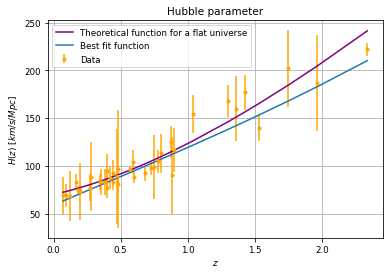

In [483]:
def best_fit(x):
    return ((x)+1)/0.13591976111017023/(0.4993533628025927)**3+(x)**3
    
yerr = desv
# Configurar el tamaño de fuente global
plt.rcParams.update({'font.size': 8.7})
#plt.figure(dpi=300)
plt.xlabel('$ z $')
plt.ylabel('$ H(z)$ $[km/s/Mpc] $')
plt.title('Hubble parameter')

omega_0 = 1
omega_k = 1 - omega_0
plt.plot(array_z, H_t(array_z), color = 'purple', label='Theoretical function for a flat universe')
plt.plot(z, best_fit(z), label= 'Best fit function')
#plt.plot(z, best_fit[1](z), label= 'Best fit function 2')
#plt.plot(z, best_fit[2](z), label= 'Best fit function 3')
#plt.plot(z, best_fit[3](z), label= 'Best fit function 4')

plt.errorbar(z, H, yerr=yerr, fmt='.', color = 'orange', label = 'Data')
plt.legend()
plt.grid(True)

plt.show()


Basado en https://cienciadedatos.net/documentos/py01_optimizacion_ga